In [1]:
import numpy as np
import torch 
import h5py # pour gérer les formats de données utilisés ici 
import seaborn as sns
import matplotlib.pyplot as plt

# TP3: Reconnaissance de signaux de communication par apprentissage profond 

<div class=consignes> Listez les noms des étudiants (2 au maximum) ayant participé à ce notebook dans la cellule suivante (prénom, nom).<br/>
Au moment du rendu, le notebook doit être nommé nom1_nom2_dlts_tp3.ipynb 

2 séances de TP sur ce sujet : le 6 novembre (1h00), le 13 novembre (3h). 
Le cours du 19 novembre sera partagé en 3 : cours sur la séparation de sources audio / présentation des mini projets et organisation des soutenances / fin de ce TP.<br> 
Deadline pour le rendu du TP: 26 novembre 2024, 13h59, par mail à deepetsignal.mva@gmail.com <br> 

Pour installer les paquets nécessaires à la réalisation de ce TP vous pouvez utiliser dans le notebook 
    
```
!pip install \< nom_du_paquet \>
```
merci de regrouper toutes les installations dans la première cellule du notebook. 
Essayez de faire en sorte que votre notebook puisse se lire comme un compte rendu, évitez de laisser du code mort et prennez le temps de commenter vos observations et résultats.

## Problématique

On cherche à identifier un type d'émetteur de communication à partir de l'observation d'un signal provenant de l'émetteur 
de 2048 échantillons IQ (In Phase / Quadrature) ie le signal prend des valeurs complexes. On représente la partie 
réelle et la partie imaginaire du signal par deux canaux réel d'un signal multivarié. 

L'émetteur peut provenir de 6 catégories différentes. 
Les paramètres différenciant les différentes catégories sont 
- le type de modulation 
- la présence ou non de séquences pilotes et le cas échéant la structure de trame pilotes / données 
- le débit de la transmission 

Les signaux se propagent en champs libre et sont enregistrés par une antenne. Le signal reçu est transposé en bande de base c'est à dire que si le signal est transmis autour d'une fréquence centrale f0, une première étape de traitement du signal à la réception recentre le signal autour de la fréquence 0. 


Les différents signaux observés dans ce TP sont entachés de différentes erreurs caractéristiques de la propagation 
électromagnétique comme : 
- modification aléatoire de la phase du signal lors de la transmission
- imperfection de la transposition en bande de base qui laisse le signal transposé à une fréquence df0 << f0
- présence d'interférence entre les symboles transmis (dûes par exemple à plusieurs chemins de propagation)
- présence d'un bruit blanc additif gaussien

Le niveau du bruit relativement à celui du signal utile est décrit par le SNR (Signal to Noise Ratio) et exprimé en dB. On suppose que le SNR est connu lors de l'acquisition d'un signal. Lors de ce TP nous rencontrerons 4 niveaux de SNR: 30 dB (facile), 20 dB, 10 dB et 0 dB (en espérant qu'on puisse faire quelque chose de ces données). 
Un de nos objectifs sera de qualifier la performance des algorithmes mis en place en fonction du SNR.

Les objectifs de ce TP sont: 

1. Définir une ou plusieurs architectures de réseaux de neurones profonds et les implémenter en PyTorch
2. Entrainer ces architectures, la fonction de perte employée pourra être la log vraisemblance négative: https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html. 
3. Qualifier les performances de votre réseau de neurones sur l'ensemble de test via: 
   - Le calcul de l'accuracy implémentée par exemple dans le package TorchMetrics (https://torchmetrics.readthedocs.io/en/stable/classification/accuracy.html)
   - La réalisation d'un graphique accuracy vs SNR 
   - La réalisation des matrices de confusion entre les différentes classes pour les différents SNR (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)
4. Rapporter les performances de vos architectures à leur complexité, la complexité d'un réseau de neurones étant ici résumé au nombre de paramètres libres qu'il fait intervenir

Durant l'entraînement on observera l'évolution de la fonction de perte et de l'accuracy sur l'ensemble d'entraînement et sur l'ensemble de validation. 


Les 4 premières parties sont un échauffement sur lequel vous pouvez passer vite si vous êtes à l'aise avec le sujet. 
Le gros du travail est dans la partie 5 "Entraînemenent d'un réseau de neurones". 

Surtout privilégiez dans un premier temps la simplicité quitte à complexifier votre approche ensuite pour doper ses performances. Ne restez pas bloqué sur des réseaux qui "mettent trop de temps à apprendre"

## Chargement des données en numpy

Le TP est composé de trois jeux de données : 
- train.hdf5 destiné à nourrir l'entrainement de réseaux de neurones 
- test.hdf5 destiné à évaluer les algorithmes après entrainement
- samples.hdf5 qui est beaucoup plus petit que train.hdf5 et destiné à servir de modèle de données dans une phase de prototypage 
des algorithmes et de la pipeline d'entrainement

Les trois jeux de données sont au format hdf5 qui peut être manipulé via l'API Python h5py https://docs.h5py.org/en/stable/quick.html.
Un fichier hdf5 est consitué d'une arborescence de datasets et de groups. Un dataset hdf5 représente un tenseur n dimensionnel. Un dataset se convertit très facilement en numpy array.

Par exemple vous pouvez charger les données samples selon la cellule suivante:

In [2]:
data_path = './samples.hdf5'

data = h5py.File(data_path, 'r')

signals = np.array(data['signaux'])
snr = np.array(data['snr'])
labels_id = np.array(data['labels'])

data.close()


Vous pouvez récupérer le nom de la correspondance entre un label et le nom du standard d'émetteur correspondant via:

In [3]:
def get_labels(open_h5_file): 
    return {
        open_h5_file['label_name'].attrs[k] : k
        for k in open_h5_file['label_name'].attrs.keys()
    }

### Visualisation des données 

Commencez par étudier les données: 

    - observez leur taille 
    - la distribution des différentes classes et des différents SNR dans l'ensemble d'entrainement 
    - visualisez quelques signaux bien choisis selon une ou des représentations que vous choisirez 

Remarque : dans ce TP il n'y a pas beaucoup à gagner à faire du feature engineering 

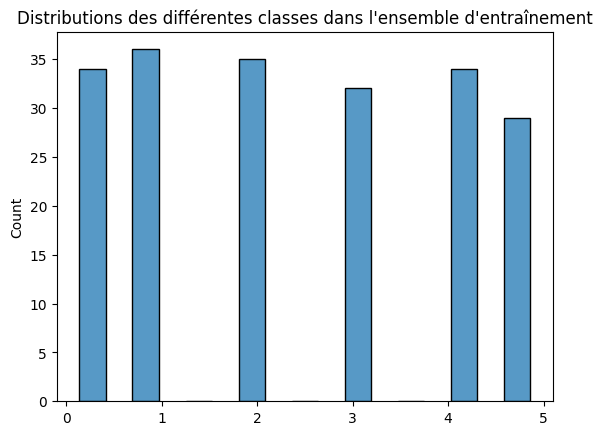

In [4]:
sns.histplot(labels_id, shrink=0.5)
plt.title("Distributions des différentes classes dans l'ensemble d'entraînement")
plt.show()


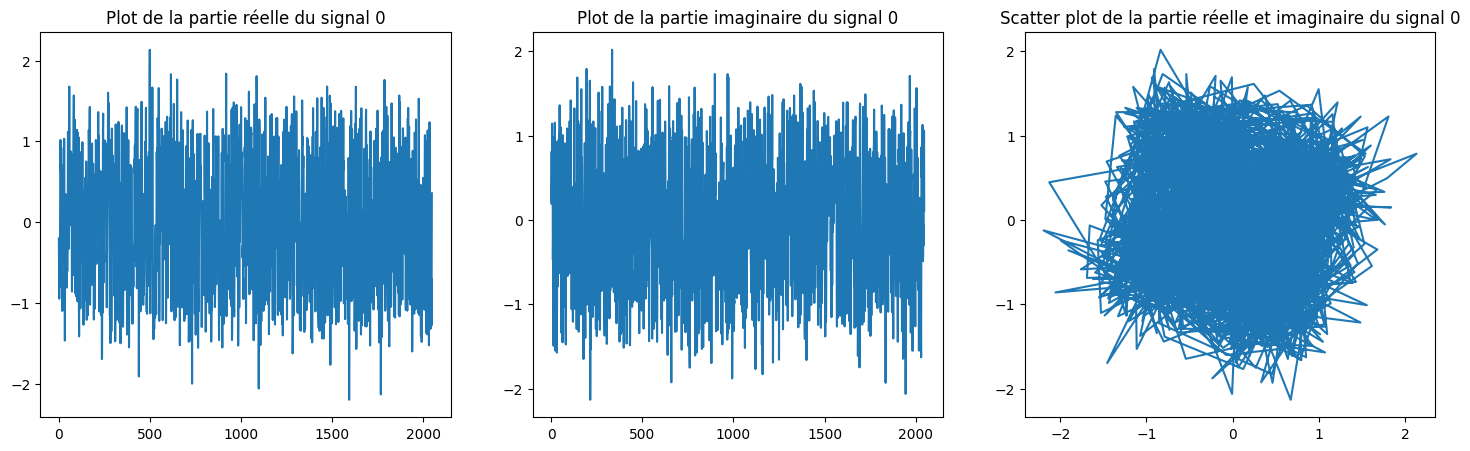

In [5]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

ax1.plot(signals[0, :, 0])
ax1.set_title("Plot de la partie réelle du signal 0")

ax2.plot(signals[0, :, 1])
ax2.set_title("Plot de la partie imaginaire du signal 0")

ax3.plot(signals[0, :, 0], signals[0, :, 1])
ax3.set_title("Scatter plot de la partie réelle et imaginaire du signal 0")

plt.show()


La troisième figure ressemble fortement à la visualisation du cour avec le passage de motif en binaire.

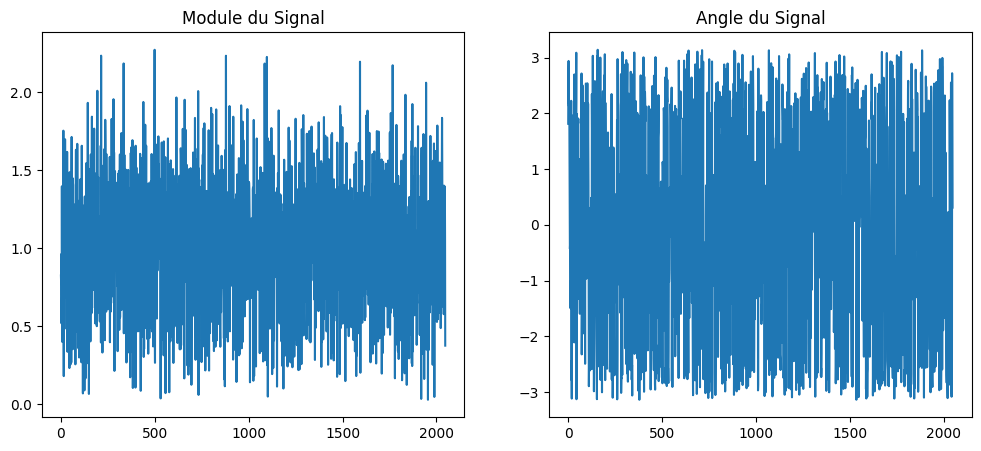

In [6]:
real_part = signals[0, :, 0]
imag_part = signals[0, :, 1]

modulus = np.sqrt(real_part**2 + imag_part**2)
angle = np.arctan2(imag_part, real_part)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(modulus)
ax1.set_title("Module du Signal")

ax2.plot(angle)
ax2.set_title("Angle du Signal")

plt.show()


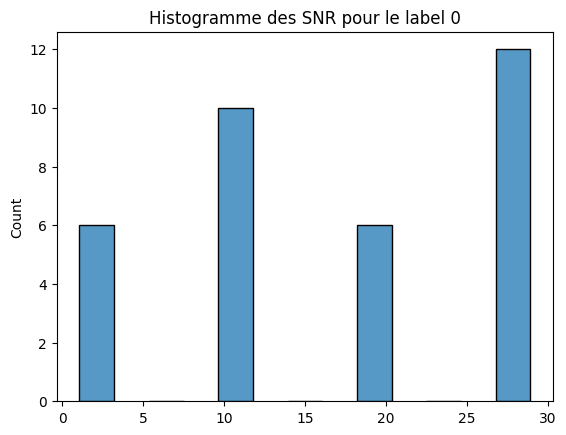

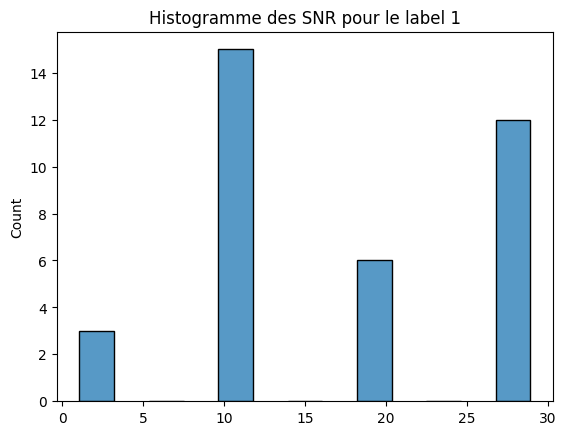

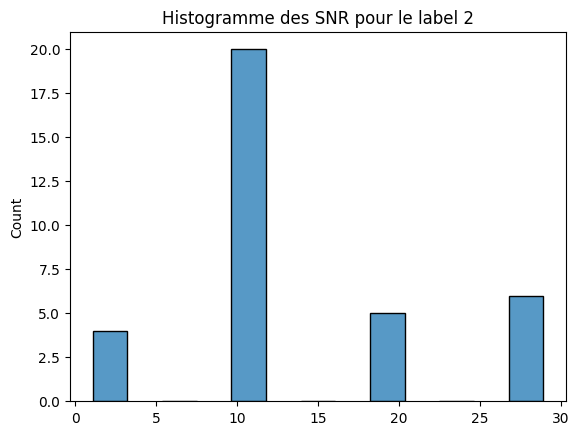

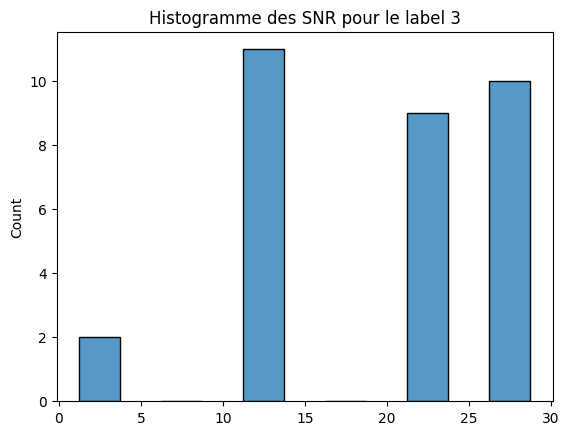

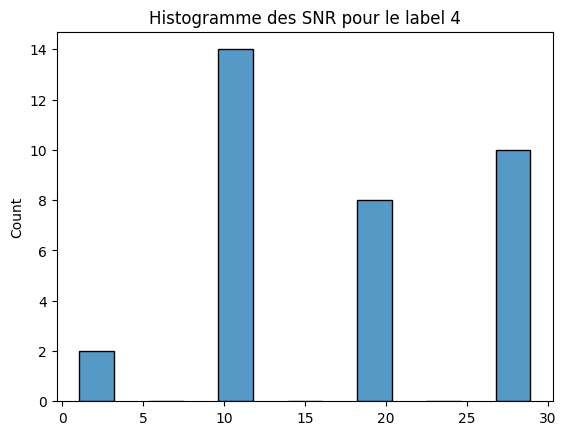

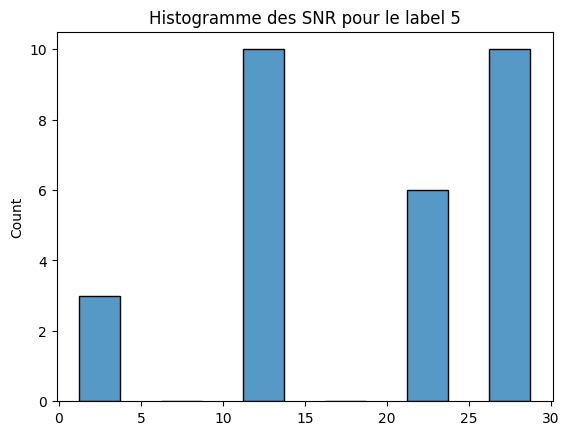

In [7]:
for i in range(0, max(labels_id) + 1):
    sns.histplot(snr[labels_id == i], shrink=0.5)
    plt.title(f"Histogramme des SNR pour le label {i}")
    plt.show()


## Chargement des données en Pytorch

Pour entrainer des réseaux de neurones profond sur nos données nous allons utiliser le framework Pytorch. 
Une première étape va consister à transférer les données de numpy à PyTorch, cela passe par deux objets : 
    - un Dataset qui modélise le dataset à haut niveau dans la mémoire de l'ordinateur
    - un Dataloader qui permet d'échantillonner le Dataset Pytorch dans les itérations de l'optimisation du réseau de neurones 
    
Un dataset prend la forme 
```python
class MyDataset(torch.utils.data.Dataset):
    
    def __init__(self, path_to_data):
        ...
    def __len__(self): #retourne le nombre de données dans le dataset
        ...
    def __getitem__(self,i): #retourne pour chaque indice i un couple (data_i, lablel_i), data_i étant un signal et label_i le label associé au signal
        ...
```

Implémentez une classe Dataset pour le dataset considéré ici 

In [8]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, path_to_data):
        data = h5py.File(path_to_data, 'r')
        signals = torch.tensor(np.array(data['signaux']))
        labels_id = torch.tensor(np.array(data['labels']))
        snr = np.array(data['snr'])  # On le garde pour la synthèse
        self.signals = signals
        self.labels_id = labels_id
        self.snr = snr
        self.data_total = list(zip(signals, labels_id))
        data.close()
        
    def __len__(self):
        return len(self.data_total)
    
    def __getitem__(self, i):
        return self.data_total[i]

    def get_snr(self, num_snr):
        # Filtrer les indices où snr est égal à num_snr
        indices = np.where(self.snr == num_snr)[0]
        
        # Mettre à jour les signaux et labels_id
        self.signals = self.signals[indices]
        self.labels_id = self.labels_id[indices]
        
        # Mettre à jour data_total
        self.data_total = list(zip(self.signals, self.labels_id))


In [9]:
dataset = MyDataset(data_path)


Instanciez un objet dataset et testez le sur les données samples
```python
dataset = MyDataset(...)
```

Pytorch propose une classe Dataloader qui permet d'échantillonner des batchs de taille fixe à partir d'un dataset. 
La cellule suivante donne un exemple d'utilisation

In [10]:
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset, 
                        batch_size=10, 
                        shuffle=True
                       )

Testez le dataloader pour différentes valeurs de batch_size 

In [11]:
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset, 
                        batch_size=10, 
                        shuffle=True)


In [12]:
train_features, train_labels = next(iter(dataloader))
print(f"Feature batch shape: {train_features.size()}")
train_labels


Feature batch shape: torch.Size([10, 2048, 2])


tensor([1, 3, 4, 2, 4, 4, 0, 2, 3, 3], dtype=torch.int8)

## Mise en place d'un réseau "dumb" pour tester la pipeline d'entrainement

Définissez un premier modèle Pytorch qui prend en entrée un batch de données (tenseur de dimensions [B , C, T] avec B la taille du batch, C le nombre de canaux des signaux et T le nombre d'échantillons dans les signaux) et renvoie un batch de vecteur de probabilités (ou de log probabilités si vous préférez) (tenseur de dimensions [B,N] où N est le nombre de classe à identifier). 

Ce modèle doit comporter moins de 10000 paramètres libres. 

Ce Modèle doit être très simple, il doit être rapide à exécuter, il servira à tester et éventuellement débugger la pipeline d'entrainement que vous mettrez en place un peu plus loin. Un template d'implémentation d'une classe Model se trouve dans les diapositives du cours.

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DumbModel(nn.Module):
    
    def __init__(self):
        super(DumbModel, self).__init__()

        # Linear layer to reduce 4096 features to 2
        self.linear1 = nn.Linear(4096, 2)

        # Activation function
        self.activation = nn.ReLU()

        # Second linear layer to go from 2 to 10 classes
        self.linear2 = nn.Linear(2, 6)
        
    def forward(self, x):
        
        # Ensure the input x has the correct shape [batch, 2048, 2]
        batch_size = x.size(0)  # Dynamic batch size
        
        # Reshape x from [batch, 2048, 2] to [batch, 4096]
        x = x.view(batch_size, -1)  # Flatten last two dimensions

        # Pass through the first linear layer
        x = self.linear1(x)

        # Apply activation function
        x = self.activation(x)

        # Pass through the second linear layer
        x = self.linear2(x)
        
        # Apply log_softmax for final class probabilities in log space
        x = F.log_softmax(x, dim=-1)
        
        return x  # Return the output directly





In [23]:
dumbmodel = DumbModel()
train(
    model=dumbmodel,
    dataloader_train=dataloader_train,
    dataloader_val=dataloader_val,
    save_path='./weight/dumbmodel.pth',
    n_epochs=20,
    learning_rate=0.001
)

C:\Users\DAO.EZSPACE\anaconda3\envs\mva2\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Model saved with improved validation loss: 1.7896 at epoch 1
Epoch 1/20, Training Loss: 1.8031, Validation Loss: 1.7896, LR: 0.001000
Epoch 2/20, Training Loss: 1.7607, Validation Loss: 1.7993, LR: 0.001000
Epoch 3/20, Training Loss: 1.7195, Validation Loss: 1.8102, LR: 0.001000
Epoch 4/20, Training Loss: 1.6851, Validation Loss: 1.8441, LR: 0.001000
Epoch 5/20, Training Loss: 1.6592, Validation Loss: 1.8785, LR: 0.001000
Epoch 6/20, Training Loss: 1.6422, Validation Loss: 1.9009, LR: 0.001000
Epoch 7/20, Training Loss: 1.6262, Validation Loss: 1.9327, LR: 0.000500
Epoch 8/20, Training Loss: 1.5880, Validation Loss: 2.0061, LR: 0.000500
Epoch 9/20, Training Loss: 1.5703, Validation Loss: 2.0603, LR: 0.000500
Epoch 10/20, Training Loss: 1.5605, Validation Loss: 2.1105, LR: 0.000500
Epoch 11/20, Training Loss: 1.5533, Validation Loss: 2.1475, LR: 0.000500


KeyboardInterrupt: 

Instanciez votre modèle et testez la consistence de ses entrées / sorties vis à vis des données étudiées (test purement fonctionnel, pas besoin de chercher à réaliser un entraînement à ce point).

In [62]:
dumbmodel(next(iter(dataloader))[0])[0]


tensor([-2.1145, -1.8082, -1.4863, -1.3267, -2.0783, -2.3159],
       grad_fn=<SelectBackward0>)

Estimez par un calcul "théorique" le nombre de paramètres du modèle que vous avez défini et vérifié que le modèle a bien ce nombre de paramètres en pratique par exemple en utilisant la fonction suivante : 

In [63]:
def count_n_param(model):
    return sum([p.numel() for p in model.parameters()])

Calcul theorique :

- On connecte en fully connected 4096 entrée à 2 neurones + 2 biais : 4096*2 + 2
- On connecte en fully connected 2 neurones à 6 neurones + 6 biais : 6*2 + 6 
- Le total de paramètres est 8212

In [68]:
count_n_param(dumbmodel)


8212

In [18]:
data_path_train = './train.hdf5'
data_path_val = './validation.hdf5'
data_path_test = './test.hdf5'

dataset_train = MyDataset(data_path_train)
dataset_val = MyDataset(data_path_val)
dataset_test = MyDataset(data_path_test)

from torch.utils.data import DataLoader

dataloader_train = DataLoader(dataset_train, 
                              batch_size=10, 
                              shuffle=True)
dataloader_val = DataLoader(dataset_val,
                            batch_size=10,
                            shuffle=False)
dataloader_test = DataLoader(dataset_test,
                             batch_size=10,
                             shuffle=False)


## Mise en place de la pipeline d'entraînement

La pipeline d'entrainement consiste à 
- charger les données 
- les batcher 
- réaliser des itération (epochs) de descente de gradient pour optimiser les paramètres d'un algorithme selon une fonction de perte (loss)
- logger l'évolution au fil des epochs  de la loss sur l'ensemble train et l'ensemble de validation et éventuellement de métriques complémentaires 

Un cavnevas d'implémentation pourrait être:

```python
device = 'cpu' # set so 'cuda:xx' if you have a GPU, xx is GPU index. L'entraînement des réseaux de neurones est grandement accéléré par l'utilisation d'un GPU 

model = ...  # vous instanciez ici votre modèle

loss = .... # définissez la fonction de perte selon laquelle le modèle sera optimisé

optimizer = torch.optim.Adam(model.parameters()) # en pratique on utilise pas une simple descente de gradient mais une procédure d'optimisation plus sophistiquée qui est implémentée sous la forme d'un objet Optimizer. Il en existe beaucoup d'optimizers différents, vous pouvez en tester différents, je vous propose d'utiliser en premier lieu l'algorithme Adam

n_epochs = ... # le nombre d'itérations dans l'entrainement 

chemin_vers_sauvegarde_model = # chemin vers un fichier où vous sauvegarderez votre modèle après optimisation pour le réutiliser plus tard. 

model.to(device) # on place le modèle dans le GPU si nécessaire

for epoch in range(n_epochs):
    
    for batch_x,batch_y in dataloader_train:
        
        batch_x.to(device)
        batch_y.to(device)
        
        optimizer.zero_grad()
        
        batch_y_predicted = model(batch_x)
        
        l = loss(batch_y_predicted, batch_y)
        # loggez la loss sur le batch d'entraînement
        
        l.backward()
        
        optimizer.step()
        
    for batch_x,batch_y in dataloader_valid:
        
        batch_x.to(device)
        batch_y.to(device)
        
        with torch.no_grad():
            batch_y_predicted = model(batch_x)  
            
        # loggez la loss et les métriques sur le batch de validation

torch.save(model, chemin_vers_sauvegarde_model)

```

Mettez en place votre pipeline et testez là sur votre modèle dumb. Faites en sorte que votre façon de logger les loss et les métriques vous permette de visualiser l'évolution de ces différents indicateurs sur l'ensemble d'entrainement et de validation au fil des epochs. 

In [19]:
import numpy as np

device = 'cuda'  # Set to 'cuda:xx' if you have a GPU; xx is the GPU index.

model = DumbModel()  # Instantiate your model here

loss = nn.NLLLoss()  # Define the loss function
optimizer = torch.optim.Adam(model.parameters())  # Optimizer (Adam)

n_epochs = 10  # Number of training epochs
chemin_vers_sauvegarde_model = "./model.pth"  # Path to save the model

model.to(device)  # Move the model to the GPU if necessary

for epoch in range(n_epochs):
    model.train()  # Set the model to training mode
    train_losses = []  # List to store training losses

    for batch_x, batch_y in dataloader_train:
        batch_x, batch_y = batch_x.to(device), batch_y.long().to(device)  # Move data to device
        
        optimizer.zero_grad()  # Zero out the gradients

        batch_y_predicted = model(batch_x)  # Forward pass
        
        # Calculate the training loss
        l = loss(batch_y_predicted, batch_y)
        train_losses.append(l.item())  # Accumulate training loss
        
        l.backward()  # Backward pass
        optimizer.step()  # Update model parameters

    # Calculate mean training loss for the epoch
    mean_train_loss = np.mean(train_losses)

    model.eval()  # Set the model to evaluation mode for validation
    with torch.no_grad():
        val_losses = []  # List to accumulate validation losses
        
        for batch_x, batch_y in dataloader_val:
            batch_x, batch_y = batch_x.to(device), batch_y.long().to(device)

            batch_y_predicted = model(batch_x)  # Forward pass for validation
            
            # Calculate the validation loss
            l = loss(batch_y_predicted, batch_y)
            val_losses.append(l.item())  # Append the validation loss

        # Calculate mean validation loss for the epoch
        mean_val_loss = np.mean


In [22]:
evaluate_metrics(dumbmodel, "./weight/dumbmodel.pth", dataloader_test, device='cuda')


C:\Users\DAO.EZSPACE\AppData\Local\Temp\ipykernel_10856\1244942837.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))


Accuracy: 17.93%
Precision: 10.97%
Recall: 17.93%
F1 Score: 11.28%


C:\Users\DAO.EZSPACE\anaconda3\envs\mva2\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(0.1793, 0.10968027112556782, 0.1793, 0.11281425176406853)

Dumb modèle a un score très bas, moins bon que l'aléatoire.

Vérifiez que vous avez bien enregistré votre modèle en fin d'entrainement. Chargez le avec la fonction 
```python
modele = torch.load(...) 
```
et vérifiez que vous pouvez l'utiliser sur des données du problème.

## Entraînement de réseaux de neurones

Dans cette partie vous définissez une ou plusieurs architecture de réseaux de neurones profonds et vous les réglez sur les données d'entrainement. 
Vous pouvez notamment utiliser des réseaux à base de convolutions et/ou de couches réurrentes. Vous pouvez vous inspirer de ce qui a été dit en cours sur la reconnaissance vocale.

Dans un deuxième temps (facultatif), si vous le souhaitez vous pouvez mettre en place des stratégies d'augmentation de données pour améliorer vos résultats. Pour mettre l'augmentation de données en pratique pouvez vous renseigner sur l'argument collate_fn du dataloader standard de Pytorch. 

## Fontion d'entrainement, inférence, metrique

In [15]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau

def train(model, dataloader_train, dataloader_val, save_path='./weight/Modele.pth', n_epochs=500, learning_rate=0.001):

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)

    loss_fn = nn.NLLLoss()  # Définir la fonction de perte
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # Optimizer
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)  # Scheduler

    best_val_loss = float('inf')  # Initialiser la meilleure perte de validation

    for epoch in range(n_epochs):
        model.train()  # Mettre le modèle en mode entraînement
        train_losses = []

        for batch_x, batch_y in dataloader_train:
            batch_x, batch_y = batch_x.to(device), batch_y.long().to(device)
            
            optimizer.zero_grad()
            batch_y_predicted = model(batch_x)
            
            l = loss_fn(batch_y_predicted, batch_y)
            train_losses.append(l.item())
            
            l.backward()
            optimizer.step()

        mean_train_loss = np.mean(train_losses)

        model.eval()  # Mode évaluation pour la validation
        with torch.no_grad():
            val_losses = []
            for batch_x, batch_y in dataloader_val:
                batch_x, batch_y = batch_x.to(device), batch_y.long().to(device)
                batch_y_predicted = model(batch_x)
                
                l = loss_fn(batch_y_predicted, batch_y)
                val_losses.append(l.item())

            mean_val_loss = np.mean(val_losses)

        scheduler.step(mean_val_loss)  # Ajuster le taux d'apprentissage

        # Sauvegarder le modèle si la perte de validation s'améliore
        if mean_val_loss < best_val_loss:
            best_val_loss = mean_val_loss
            torch.save(model.state_dict(), save_path)
            print(f"Model saved with improved validation loss: {best_val_loss:.4f} at epoch {epoch+1}")

        print(f"Epoch {epoch+1}/{n_epochs}, Training Loss: {mean_train_loss:.4f}, Validation Loss: {mean_val_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")


In [21]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_metrics(model, weight_path, dataloader, device='cpu'):
    # Charger les poids du modèle
    model.load_state_dict(torch.load(weight_path))
    model.to(device)
    model.eval()  # Mettre le modèle en mode évaluation
    
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():  # Pas besoin de calculer les gradients pour l'inférence
        for batch_x, batch_y in dataloader:
            # Transférer les données sur le bon device
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # Prédiction
            batch_y_predicted = model(batch_x)  # Forward pass
            
            # Obtenir les classes prédites
            _, predicted_classes = torch.max(batch_y_predicted, dim=1)
            
            # Stocker les labels réels et les prédictions
            all_labels.extend(batch_y.cpu().numpy())
            all_predictions.extend(predicted_classes.cpu().numpy())
    
    # Calculer les métriques
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    
    # Afficher les résultats
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"F1 Score: {f1 * 100:.2f}%")
    
    return accuracy, precision, recall, f1


In [176]:
import os

def plot_accuracy_error_barplot(model, weight_path, dataloaders, snrs, device='cpu', save_path=None):

    accuracyPerSNR = {}
    overall_correct = 0
    overall_total = 0

    for dataloader, snr in zip(dataloaders, snrs):
        print(f"Évaluation pour SNR={snr}...")
        accuracy, _, _, _ = evaluate_metrics(model, weight_path, dataloader, device)
        accuracyPerSNR[snr] = accuracy * 100  # Convertir en pourcentage
        
        # Mettre à jour les métriques globales
        overall_correct += accuracy * len(dataloader.dataset)
        overall_total += len(dataloader.dataset)

    # Calculer l'accuracy globale
    overall_accuracy = (overall_correct / overall_total) * 100

    # Réorganiser les données pour le graphique
    snr = list(accuracyPerSNR.keys())
    correct = [accuracyPerSNR[k] for k in snr]
    error = [100 - acc for acc in correct]

    # Paramètres du graphique
    barWidth = 2  # Ajuster la largeur des barres
    plt.figure(figsize=(10, 6)) 

    # Tracer les barres empilées
    plt.bar(snr, correct, color='#b5ffb9', edgecolor='white', width=barWidth, label="Accuracy")  # Accuracy
    plt.bar(snr, error, bottom=correct, color='#f9bc86', edgecolor='white', width=barWidth, label="Error")  # Error

    # Tracer la ligne pour l'accuracy globale
    plt.axhline(y=overall_accuracy, color='black', linestyle='dashed', label="Accuracy globale") 

    # Personnaliser le graphique
    plt.xticks(snr, [str(s) for s in snr])
    plt.xlabel("SNR (dB)")
    plt.ylabel("Accuracy/Error (%)")
    plt.title("Accuracy/Error en fonction du SNR")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)
    plt.tight_layout()

    # Sauvegarder ou afficher le graphique
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)  # Créer le dossier si nécessaire
        plt.savefig(save_path, dpi=300)
        print(f"Graphique sauvegardé à l'emplacement : {save_path}")
    else:
        plt.show()


## Modèle 1 :

In [171]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Modele1(nn.Module):
    def __init__(self):
        super(Modele1, self).__init__()

class Modele1(nn.Module):
    def __init__(self):
        super(Modele1, self).__init__()

        # Initial Convolutional Layer
        self.conv1d_1 = nn.Conv1d(2, 64, kernel_size=7, stride=2, padding=3)
        self.batchnorm_1 = nn.BatchNorm1d(64)
        self.relu1 = nn.ReLU()

        # Bloc 1
        self.conv1d_2 = nn.Conv1d(64, 64, kernel_size=3, stride=1, padding=1)
        self.batchnorm_2 = nn.BatchNorm1d(64)
        self.relu2 = nn.ReLU()

        self.conv1d_3 = nn.Conv1d(64, 64, kernel_size=3, stride=1, padding=1)
        self.batchnorm_3 = nn.BatchNorm1d(64)
        self.relu3 = nn.ReLU()

        # Bloc 2
        self.conv1d_4 = nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1)
        self.batchnorm_4 = nn.BatchNorm1d(128)
        self.relu4 = nn.ReLU()

        self.conv1d_5 = nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1)
        self.batchnorm_5 = nn.BatchNorm1d(128)
        self.relu5 = nn.ReLU()

        self.conv1d_6 = nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1)
        self.batchnorm_6 = nn.BatchNorm1d(128)
        self.relu6 = nn.ReLU()

        self.conv1d_7 = nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1)
        self.batchnorm_7 = nn.BatchNorm1d(128)
        self.relu7 = nn.ReLU()

        # Bloc 3
        self.conv1d_8 = nn.Conv1d(128, 256, kernel_size=3, stride=2, padding=1)
        self.batchnorm_8 = nn.BatchNorm1d(256)
        self.relu8 = nn.ReLU()

        self.conv1d_9 = nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1)
        self.batchnorm_9 = nn.BatchNorm1d(256)
        self.relu9 = nn.ReLU()

        self.conv1d_10 = nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1)
        self.batchnorm_10 = nn.BatchNorm1d(256)
        self.relu10 = nn.ReLU()

        self.conv1d_11 = nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1)
        self.batchnorm_11 = nn.BatchNorm1d(256)
        self.relu11 = nn.ReLU()

        self.conv1d_12 = nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1)
        self.batchnorm_12 = nn.BatchNorm1d(256)
        self.relu12 = nn.ReLU()

        self.conv1d_13 = nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1)
        self.batchnorm_13 = nn.BatchNorm1d(256)
        self.relu13 = nn.ReLU()

        # Bloc 4
        self.conv1d_14 = nn.Conv1d(256, 512, kernel_size=3, stride=2, padding=1)
        self.batchnorm_14 = nn.BatchNorm1d(512)
        self.relu14 = nn.ReLU()

        self.conv1d_15 = nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1)
        self.batchnorm_15 = nn.BatchNorm1d(512)
        self.relu15 = nn.ReLU()

        self.conv1d_16 = nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1)
        self.batchnorm_16 = nn.BatchNorm1d(512)
        self.relu16 = nn.ReLU()

        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)

        # Fully Connected Layer
        self.fc = nn.Linear(512, 6)  


    def forward(self, x):
        x = x.permute(0,2,1)
        # Initial Convolutional Layer
        x = self.conv1d_1(x)
        x = self.batchnorm_1(x)
        x = self.relu1(x)

        # Bloc 1
        x = self.conv1d_2(x)
        x = self.batchnorm_2(x)
        x = self.relu2(x)

        x = self.conv1d_3(x)
        x = self.batchnorm_3(x)
        x = self.relu3(x)

        # Bloc 2
        x = self.conv1d_4(x)
        x = self.batchnorm_4(x)
        x = self.relu4(x)

        x = self.conv1d_5(x)
        x = self.batchnorm_5(x)
        x = self.relu5(x)

        x = self.conv1d_6(x)
        x = self.batchnorm_6(x)
        x = self.relu6(x)

        x = self.conv1d_7(x)
        x = self.batchnorm_7(x)
        x = self.relu7(x)

        # Bloc 3
        x = self.conv1d_8(x)
        x = self.batchnorm_8(x)
        x = self.relu8(x)

        x = self.conv1d_9(x)
        x = self.batchnorm_9(x)
        x = self.relu9(x)

        x = self.conv1d_10(x)
        x = self.batchnorm_10(x)
        x = self.relu10(x)

        x = self.conv1d_11(x)
        x = self.batchnorm_11(x)
        x = self.relu11(x)

        x = self.conv1d_12(x)
        x = self.batchnorm_12(x)
        x = self.relu12(x)

        x = self.conv1d_13(x)
        x = self.batchnorm_13(x)
        x = self.relu13(x)

        # Bloc 4
        x = self.conv1d_14(x)
        x = self.batchnorm_14(x)
        x = self.relu14(x)

        x = self.conv1d_15(x)
        x = self.batchnorm_15(x)
        x = self.relu15(x)

        x = self.conv1d_16(x)
        x = self.batchnorm_16(x)
        x = self.relu16(x)

        # Global Average Pooling
        x = self.global_avg_pool(x)

        # Flatten for fully connected layer
        x = x.view(x.size(0), -1)

        # Fully Connected Layer
        x = self.fc(x)

        x = F.log_softmax(x, dim=-1)
        

        return x


In [172]:
(next(iter(dataloader))[0]).shape

torch.Size([10, 2048, 2])

In [173]:
model1 = Modele1()
train(
    model=model1,
    dataloader_train=dataloader_train,
    dataloader_val=dataloader_val,
    save_path='./weight/Modele1.pth',
    n_epochs=20,
    learning_rate=0.001
)

C:\Users\DAO.EZSPACE\anaconda3\envs\mva2\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


KeyboardInterrupt: 

In [106]:
evaluate_metrics(model1, "./weight/Modele1.pth", dataloader_test, device='cuda')


C:\Users\DAO.EZSPACE\AppData\Local\Temp\ipykernel_2420\1244942837.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))


Accuracy: 83.77%
Precision: 87.51%
Recall: 83.77%
F1 Score: 84.10%


(0.8377, 0.8751196445944887, 0.8377, 0.8409560212503236)

## Modele 2

On va s'inspirer du Resnet1D pour rajouter les résidue, l'idée est d'etre sur qu'il n'y ai pas de l'oublie entre les blocs de convolutions

In [114]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Modele2(nn.Module):
    def __init__(self):
        super(Modele2, self).__init__()

        # Initial Convolutional Layer
        self.conv1d_1 = nn.Conv1d(2, 64, kernel_size=7, stride=2, padding=3)
        self.batchnorm_1 = nn.BatchNorm1d(64)
        self.relu1 = nn.ReLU()

        # Bloc 1
        self.conv1d_2 = nn.Conv1d(64, 64, kernel_size=3, stride=1, padding=1)
        self.batchnorm_2 = nn.BatchNorm1d(64)
        self.relu2 = nn.ReLU()

        self.conv1d_3 = nn.Conv1d(64, 64, kernel_size=3, stride=1, padding=1)
        self.batchnorm_3 = nn.BatchNorm1d(64)
        self.relu3 = nn.ReLU()

        # Bloc 2
        self.conv1d_4 = nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1)
        self.batchnorm_4 = nn.BatchNorm1d(128)
        self.relu4 = nn.ReLU()

        self.conv1d_5 = nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1)
        self.batchnorm_5 = nn.BatchNorm1d(128)
        self.relu5 = nn.ReLU()

        self.conv1d_6 = nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1)
        self.batchnorm_6 = nn.BatchNorm1d(128)
        self.relu6 = nn.ReLU()

        self.conv1d_7 = nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1)
        self.batchnorm_7 = nn.BatchNorm1d(128)
        self.relu7 = nn.ReLU()

        self.residual_downsample_2 = nn.Conv1d(64, 128, kernel_size=1, stride=2)

        # Bloc 3
        self.conv1d_8 = nn.Conv1d(128, 256, kernel_size=3, stride=2, padding=1)
        self.batchnorm_8 = nn.BatchNorm1d(256)
        self.relu8 = nn.ReLU()

        self.conv1d_9 = nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1)
        self.batchnorm_9 = nn.BatchNorm1d(256)
        self.relu9 = nn.ReLU()

        self.conv1d_10 = nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1)
        self.batchnorm_10 = nn.BatchNorm1d(256)
        self.relu10 = nn.ReLU()

        self.conv1d_11 = nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1)
        self.batchnorm_11 = nn.BatchNorm1d(256)
        self.relu11 = nn.ReLU()

        self.conv1d_12 = nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1)
        self.batchnorm_12 = nn.BatchNorm1d(256)
        self.relu12 = nn.ReLU()

        self.conv1d_13 = nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1)
        self.batchnorm_13 = nn.BatchNorm1d(256)
        self.relu13 = nn.ReLU()

        self.residual_downsample_3 = nn.Conv1d(128, 256, kernel_size=1, stride=2)

        # Bloc 4
        self.conv1d_14 = nn.Conv1d(256, 512, kernel_size=3, stride=2, padding=1)
        self.batchnorm_14 = nn.BatchNorm1d(512)
        self.relu14 = nn.ReLU()

        self.conv1d_15 = nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1)
        self.batchnorm_15 = nn.BatchNorm1d(512)
        self.relu15 = nn.ReLU()

        self.conv1d_16 = nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1)
        self.batchnorm_16 = nn.BatchNorm1d(512)
        self.relu16 = nn.ReLU()

        self.residual_downsample_4 = nn.Conv1d(256, 512, kernel_size=1, stride=2)

        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)

        # Fully Connected Layer
        self.fc = nn.Linear(512, 6)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Réorganiser les dimensions si nécessaire (batch_size, channels, seq_len)

        # Initial Convolutional Layer
        x = self.conv1d_1(x)
        x = self.batchnorm_1(x)
        x = self.relu1(x)

        # Bloc 1
        residual = x  # Connexion résiduelle
        x = self.conv1d_2(x)
        x = self.batchnorm_2(x)
        x = self.relu2(x)

        x = self.conv1d_3(x)
        x = self.batchnorm_3(x)
        x = self.relu3(x)

        x = x + residual  # Ajouter la connexion résiduelle

        # Bloc 2
        residual = self.residual_downsample_2(x)  # Adapter la dimension pour le downsampling
        x = self.conv1d_4(x)
        x = self.batchnorm_4(x)
        x = self.relu4(x)

        x = self.conv1d_5(x)
        x = self.batchnorm_5(x)
        x = self.relu5(x)

        x = self.conv1d_6(x)
        x = self.batchnorm_6(x)
        x = self.relu6(x)

        x = self.conv1d_7(x)
        x = self.batchnorm_7(x)
        x = self.relu7(x)

        x = x + residual  # Ajouter la connexion résiduelle

        # Bloc 3
        residual = self.residual_downsample_3(x)  # Adapter la dimension pour le downsampling
        x = self.conv1d_8(x)
        x = self.batchnorm_8(x)
        x = self.relu8(x)

        x = self.conv1d_9(x)
        x = self.batchnorm_9(x)
        x = self.relu9(x)

        x = self.conv1d_10(x)
        x = self.batchnorm_10(x)
        x = self.relu10(x)

        x = self.conv1d_11(x)
        x = self.batchnorm_11(x)
        x = self.relu11(x)

        x = self.conv1d_12(x)
        x = self.batchnorm_12(x)
        x = self.relu12(x)

        x = self.conv1d_13(x)
        x = self.batchnorm_13(x)
        x = self.relu13(x)

        x = x + residual  # Ajouter la connexion résiduelle

        # Bloc 4
        residual = self.residual_downsample_4(x)  # Adapter la dimension pour le downsampling
        x = self.conv1d_14(x)
        x = self.batchnorm_14(x)
        x = self.relu14(x)

        x = self.conv1d_15(x)
        x = self.batchnorm_15(x)
        x = self.relu15(x)

        x = self.conv1d_16(x)
        x = self.batchnorm_16(x)
        x = self.relu16(x)

        x = x + residual  # Ajouter la connexion résiduelle

        # Global Average Pooling
        x = self.global_avg_pool(x)

        # Flatten for fully connected layer
        x = x.view(x.size(0), -1)

        # Fully Connected Layer
        x = self.fc(x)

        x = F.log_softmax(x, dim=-1)

        return x


In [115]:
model2 = Modele2()
train(
    model=model2,
    dataloader_train=dataloader_train,
    dataloader_val=dataloader_val,
    save_path='./weight/Modele2.pth',
    n_epochs=20,
    learning_rate=0.001
)

Model saved with improved validation loss: 0.7415 at epoch 1
Epoch 1/20, Training Loss: 0.8995, Validation Loss: 0.7415, LR: 0.001000
Model saved with improved validation loss: 0.5436 at epoch 2
Epoch 2/20, Training Loss: 0.7293, Validation Loss: 0.5436, LR: 0.001000
Model saved with improved validation loss: 0.4911 at epoch 3
Epoch 3/20, Training Loss: 0.5951, Validation Loss: 0.4911, LR: 0.001000
Epoch 4/20, Training Loss: 0.5371, Validation Loss: 0.6105, LR: 0.001000
Model saved with improved validation loss: 0.4641 at epoch 5
Epoch 5/20, Training Loss: 0.5052, Validation Loss: 0.4641, LR: 0.001000
Model saved with improved validation loss: 0.4618 at epoch 6
Epoch 6/20, Training Loss: 0.4923, Validation Loss: 0.4618, LR: 0.001000
Epoch 7/20, Training Loss: 0.4828, Validation Loss: 0.7577, LR: 0.001000
Model saved with improved validation loss: 0.4478 at epoch 8
Epoch 8/20, Training Loss: 0.4752, Validation Loss: 0.4478, LR: 0.001000
Epoch 9/20, Training Loss: 0.4645, Validation Loss

In [ ]:
model2 = Modele2()
train(
    model=model2,
    dataloader_train=dataloader_train,
    dataloader_val=dataloader_val,
    save_path='./weight/Modele2.pth',
    n_epochs=20,
    learning_rate=0.001
)

In [116]:
evaluate_metrics(model2, "./weight/Modele2.pth", dataloader_test, device='cuda')


C:\Users\DAO.EZSPACE\AppData\Local\Temp\ipykernel_2420\1244942837.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))


Accuracy: 85.90%
Precision: 85.98%
Recall: 85.90%
F1 Score: 85.83%


(0.859, 0.8598389932969938, 0.859, 0.8583055558881993)

## Modele 3 :

On regarde si on peut pas améliorer l'entrainement en diminuant le nombre de couche de convolution dans les blocs

In [123]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Modele3(nn.Module):
    def __init__(self):
        super(Modele3, self).__init__()

        # Initial Convolutional Layer
        self.conv1d_1 = nn.Conv1d(2, 64, kernel_size=7, stride=2, padding=3)
        self.batchnorm_1 = nn.BatchNorm1d(64)
        self.relu1 = nn.ReLU()

        # Bloc 1
        self.conv1d_2 = nn.Conv1d(64, 64, kernel_size=3, stride=1, padding=1)
        self.batchnorm_2 = nn.BatchNorm1d(64)
        self.relu2 = nn.ReLU()

        self.residual_downsample_1 = nn.Identity()  # Pas de changement de dimensions

        # Bloc 2
        self.conv1d_3 = nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1)
        self.batchnorm_3 = nn.BatchNorm1d(128)
        self.relu3 = nn.ReLU()

        self.conv1d_4 = nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1)
        self.batchnorm_4 = nn.BatchNorm1d(128)
        self.relu4 = nn.ReLU()

        self.residual_downsample_2 = nn.Conv1d(64, 128, kernel_size=1, stride=2)

        # Bloc 3
        self.conv1d_5 = nn.Conv1d(128, 256, kernel_size=3, stride=2, padding=1)
        self.batchnorm_5 = nn.BatchNorm1d(256)
        self.relu5 = nn.ReLU()

        self.conv1d_6 = nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1)
        self.batchnorm_6 = nn.BatchNorm1d(256)
        self.relu6 = nn.ReLU()

        self.conv1d_7 = nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1)
        self.batchnorm_7 = nn.BatchNorm1d(256)
        self.relu7 = nn.ReLU()

        self.residual_downsample_3 = nn.Conv1d(128, 256, kernel_size=1, stride=2)

        # Bloc 4
        self.conv1d_8 = nn.Conv1d(256, 512, kernel_size=3, stride=2, padding=1)
        self.batchnorm_8 = nn.BatchNorm1d(512)
        self.relu8 = nn.ReLU()

        self.conv1d_9 = nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1)
        self.batchnorm_9 = nn.BatchNorm1d(512)
        self.relu9 = nn.ReLU()

        self.residual_downsample_4 = nn.Conv1d(256, 512, kernel_size=1, stride=2)

        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)

        # Fully Connected Layer
        self.fc = nn.Linear(512, 6)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Réorganiser les dimensions si nécessaire (batch_size, channels, seq_len)

        # Initial Convolutional Layer
        x = self.conv1d_1(x)
        x = self.batchnorm_1(x)
        x = self.relu1(x)

        # Bloc 1
        residual = self.residual_downsample_1(x)
        x = self.conv1d_2(x)
        x = self.batchnorm_2(x)
        x = self.relu2(x)
        x = x + residual  # Ajouter la connexion résiduelle

        # Bloc 2
        residual = self.residual_downsample_2(x)
        x = self.conv1d_3(x)
        x = self.batchnorm_3(x)
        x = self.relu3(x)

        x = self.conv1d_4(x)
        x = self.batchnorm_4(x)
        x = self.relu4(x)
        x = x + residual  # Ajouter la connexion résiduelle

        # Bloc 3
        residual = self.residual_downsample_3(x)
        x = self.conv1d_5(x)
        x = self.batchnorm_5(x)
        x = self.relu5(x)

        x = self.conv1d_6(x)
        x = self.batchnorm_6(x)
        x = self.relu6(x)

        x = self.conv1d_7(x)
        x = self.batchnorm_7(x)
        x = self.relu7(x)
        x = x + residual  # Ajouter la connexion résiduelle

        # Bloc 4
        residual = self.residual_downsample_4(x)
        x = self.conv1d_8(x)
        x = self.batchnorm_8(x)
        x = self.relu8(x)

        x = self.conv1d_9(x)
        x = self.batchnorm_9(x)
        x = self.relu9(x)
        x = x + residual  # Ajouter la connexion résiduelle

        # Global Average Pooling
        x = self.global_avg_pool(x)

        # Flatten for fully connected layer
        x = x.view(x.size(0), -1)

        # Fully Connected Layer
        x = self.fc(x)

        x = F.log_softmax(x, dim=-1)

        return x


In [124]:
model3 = Modele3()
train(
    model=model3,
    dataloader_train=dataloader_train,
    dataloader_val=dataloader_val,
    save_path='./weight/Modele3.pth',
    n_epochs=20,
    learning_rate=0.001
)

C:\Users\DAO.EZSPACE\anaconda3\envs\mva2\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Model saved with improved validation loss: 0.6803 at epoch 1
Epoch 1/20, Training Loss: 0.8787, Validation Loss: 0.6803, LR: 0.001000
Model saved with improved validation loss: 0.6801 at epoch 2
Epoch 2/20, Training Loss: 0.7293, Validation Loss: 0.6801, LR: 0.001000
Model saved with improved validation loss: 0.5015 at epoch 3
Epoch 3/20, Training Loss: 0.5998, Validation Loss: 0.5015, LR: 0.001000
Model saved with improved validation loss: 0.4904 at epoch 4
Epoch 4/20, Training Loss: 0.5519, Validation Loss: 0.4904, LR: 0.001000
Epoch 5/20, Training Loss: 0.4995, Validation Loss: 0.5394, LR: 0.001000
Model saved with improved validation loss: 0.3084 at epoch 6
Epoch 6/20, Training Loss: 0.3918, Validation Loss: 0.3084, LR: 0.001000
Model saved with improved validation loss: 0.3080 at epoch 7
Epoch 7/20, Training Loss: 0.3539, Validation Loss: 0.3080, LR: 0.001000
Model saved with improved validation loss: 0.2958 at epoch 8
Epoch 8/20, Training Loss: 0.3324, Validation Loss: 0.2958, LR

In [125]:
evaluate_metrics(model3, "./weight/Modele3.pth", dataloader_test, device='cuda')


C:\Users\DAO.EZSPACE\AppData\Local\Temp\ipykernel_2420\1244942837.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))


Accuracy: 85.52%
Precision: 87.45%
Recall: 85.52%
F1 Score: 85.57%


(0.8552, 0.8745385815839624, 0.8552, 0.8557163892515307)

## Synthèse de résultats 

Une fois que votre ou vos réseaux sont entrainez vous comparez leurs performances selon les métriques définies en introduction sur l'ensemble de test sans oublier de mesurer également la complexité de chaque approche en termes de nombre de paramètres. Si vous avez testé des approches qui vous semblent avoir échoué vous pouvez rédiger un petit paragraphe pour expliquer votre analyse de cet échec. 

Pour les réseaux nous nous sommes inspirés de l'article Time Series from Scratch with Deep Neural Networks : https://arxiv.org/pdf/1611.06455



Le premier modèle, **Modele1**, utilise un FCN (Fully Convolutional Network). 
Nous nous inspirons des différentes couches du ResNet pour capturer des caractéristiques à différents niveaux de détail.

Dans le deuxième modèle, nous explorons si le FCN peut être amélioré en ajoutant une notion de résidu, 
permettant de rappeler les informations initiales dans le calcul des nouvelles représentations.

Cependant, nous constatons que **Modele1** et **Modele2** sont lents à entraîner. Nous proposons alors de conserver la même idée, 
mais en simplifiant le modèle en réduisant le nombre de couches. Cela aboutit à notre modèle final, **Modele3**.

D'autres approches ont été testées, mais elles ne sont pas présentées ici. Nous avons par exemple utilisé des GRU et des LSTM, 
mais les résultats n'étaient pas satisfaisants. Nous avons également expérimenté des convolutions 2D avec des données sous la forme 
(batch_size, channels=1, partie réelle, partie imaginaire), mais cela compliquait le code sans amélioration notable des performances.

Nous allons maintenant proposer une synthèse de nos résultats sur le **Modele3**



In [177]:
data_path_test = './test.hdf5'

dataset_test_snr0 = MyDataset(data_path_test)
dataset_test_snr0.get_snr(0)

dataset_test_snr10 = MyDataset(data_path_test)
dataset_test_snr10.get_snr(10)

dataset_test_snr20 = MyDataset(data_path_test)
dataset_test_snr20.get_snr(20)

dataset_test_snr30 = MyDataset(data_path_test)
dataset_test_snr30.get_snr(30)

dataloader_test_snr0 = DataLoader(dataset_test_snr0,
                             batch_size=10,
                             shuffle=False)

dataloader_test_snr10 = DataLoader(dataset_test_snr10,
                             batch_size=10,
                             shuffle=False)

dataloader_test_snr20 = DataLoader(dataset_test_snr20,
                             batch_size=10,
                             shuffle=False)

dataloader_test_snr30 = DataLoader(dataset_test_snr30,
                             batch_size=10,
                             shuffle=False)


dataloaders_by_snr = [
    dataloader_test_snr0, 
    dataloader_test_snr10, 
    dataloader_test_snr20, 
    dataloader_test_snr30
]
snrs = [0, 10, 20, 30]


Évaluation pour SNR=0...


C:\Users\DAO.EZSPACE\AppData\Local\Temp\ipykernel_2420\1244942837.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))


Accuracy: 41.36%
Precision: 40.66%
Recall: 41.36%
F1 Score: 33.78%
Évaluation pour SNR=10...


C:\Users\DAO.EZSPACE\AppData\Local\Temp\ipykernel_2420\1244942837.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))


Accuracy: 98.88%
Precision: 98.92%
Recall: 98.88%
F1 Score: 98.88%
Évaluation pour SNR=20...


C:\Users\DAO.EZSPACE\AppData\Local\Temp\ipykernel_2420\1244942837.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))


Accuracy: 100.00%
Precision: 100.00%
Recall: 100.00%
F1 Score: 100.00%
Évaluation pour SNR=30...


C:\Users\DAO.EZSPACE\AppData\Local\Temp\ipykernel_2420\1244942837.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))


Accuracy: 100.00%
Precision: 100.00%
Recall: 100.00%
F1 Score: 100.00%
Graphique sauvegardé à l'emplacement : ./modele3plot.jpg


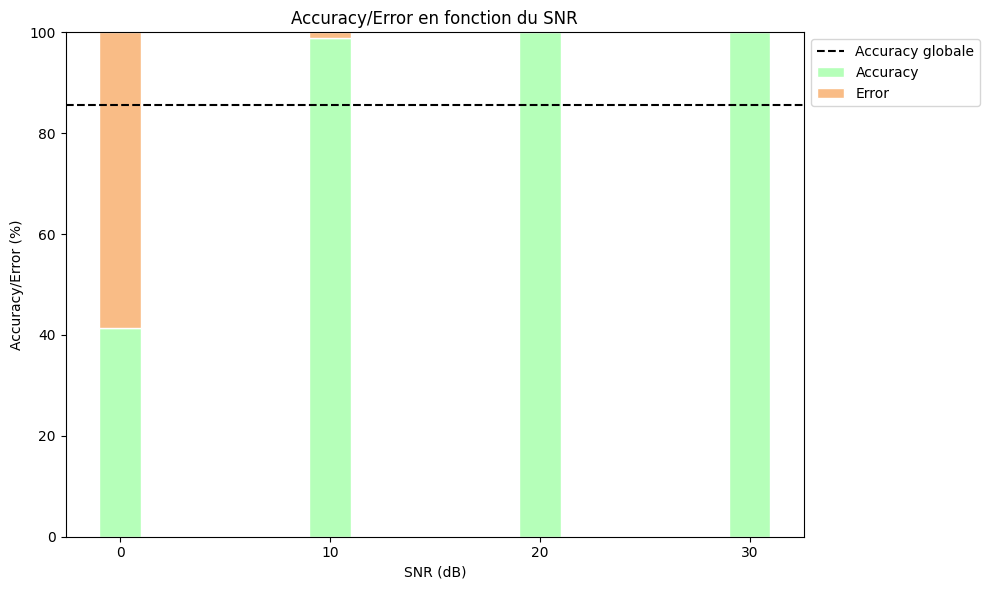

In [190]:
plot_accuracy_error_barplot(model3, "./weight/Modele3.pth", dataloaders_by_snr, snrs, device='cuda',save_path='./modele3plot.jpg')


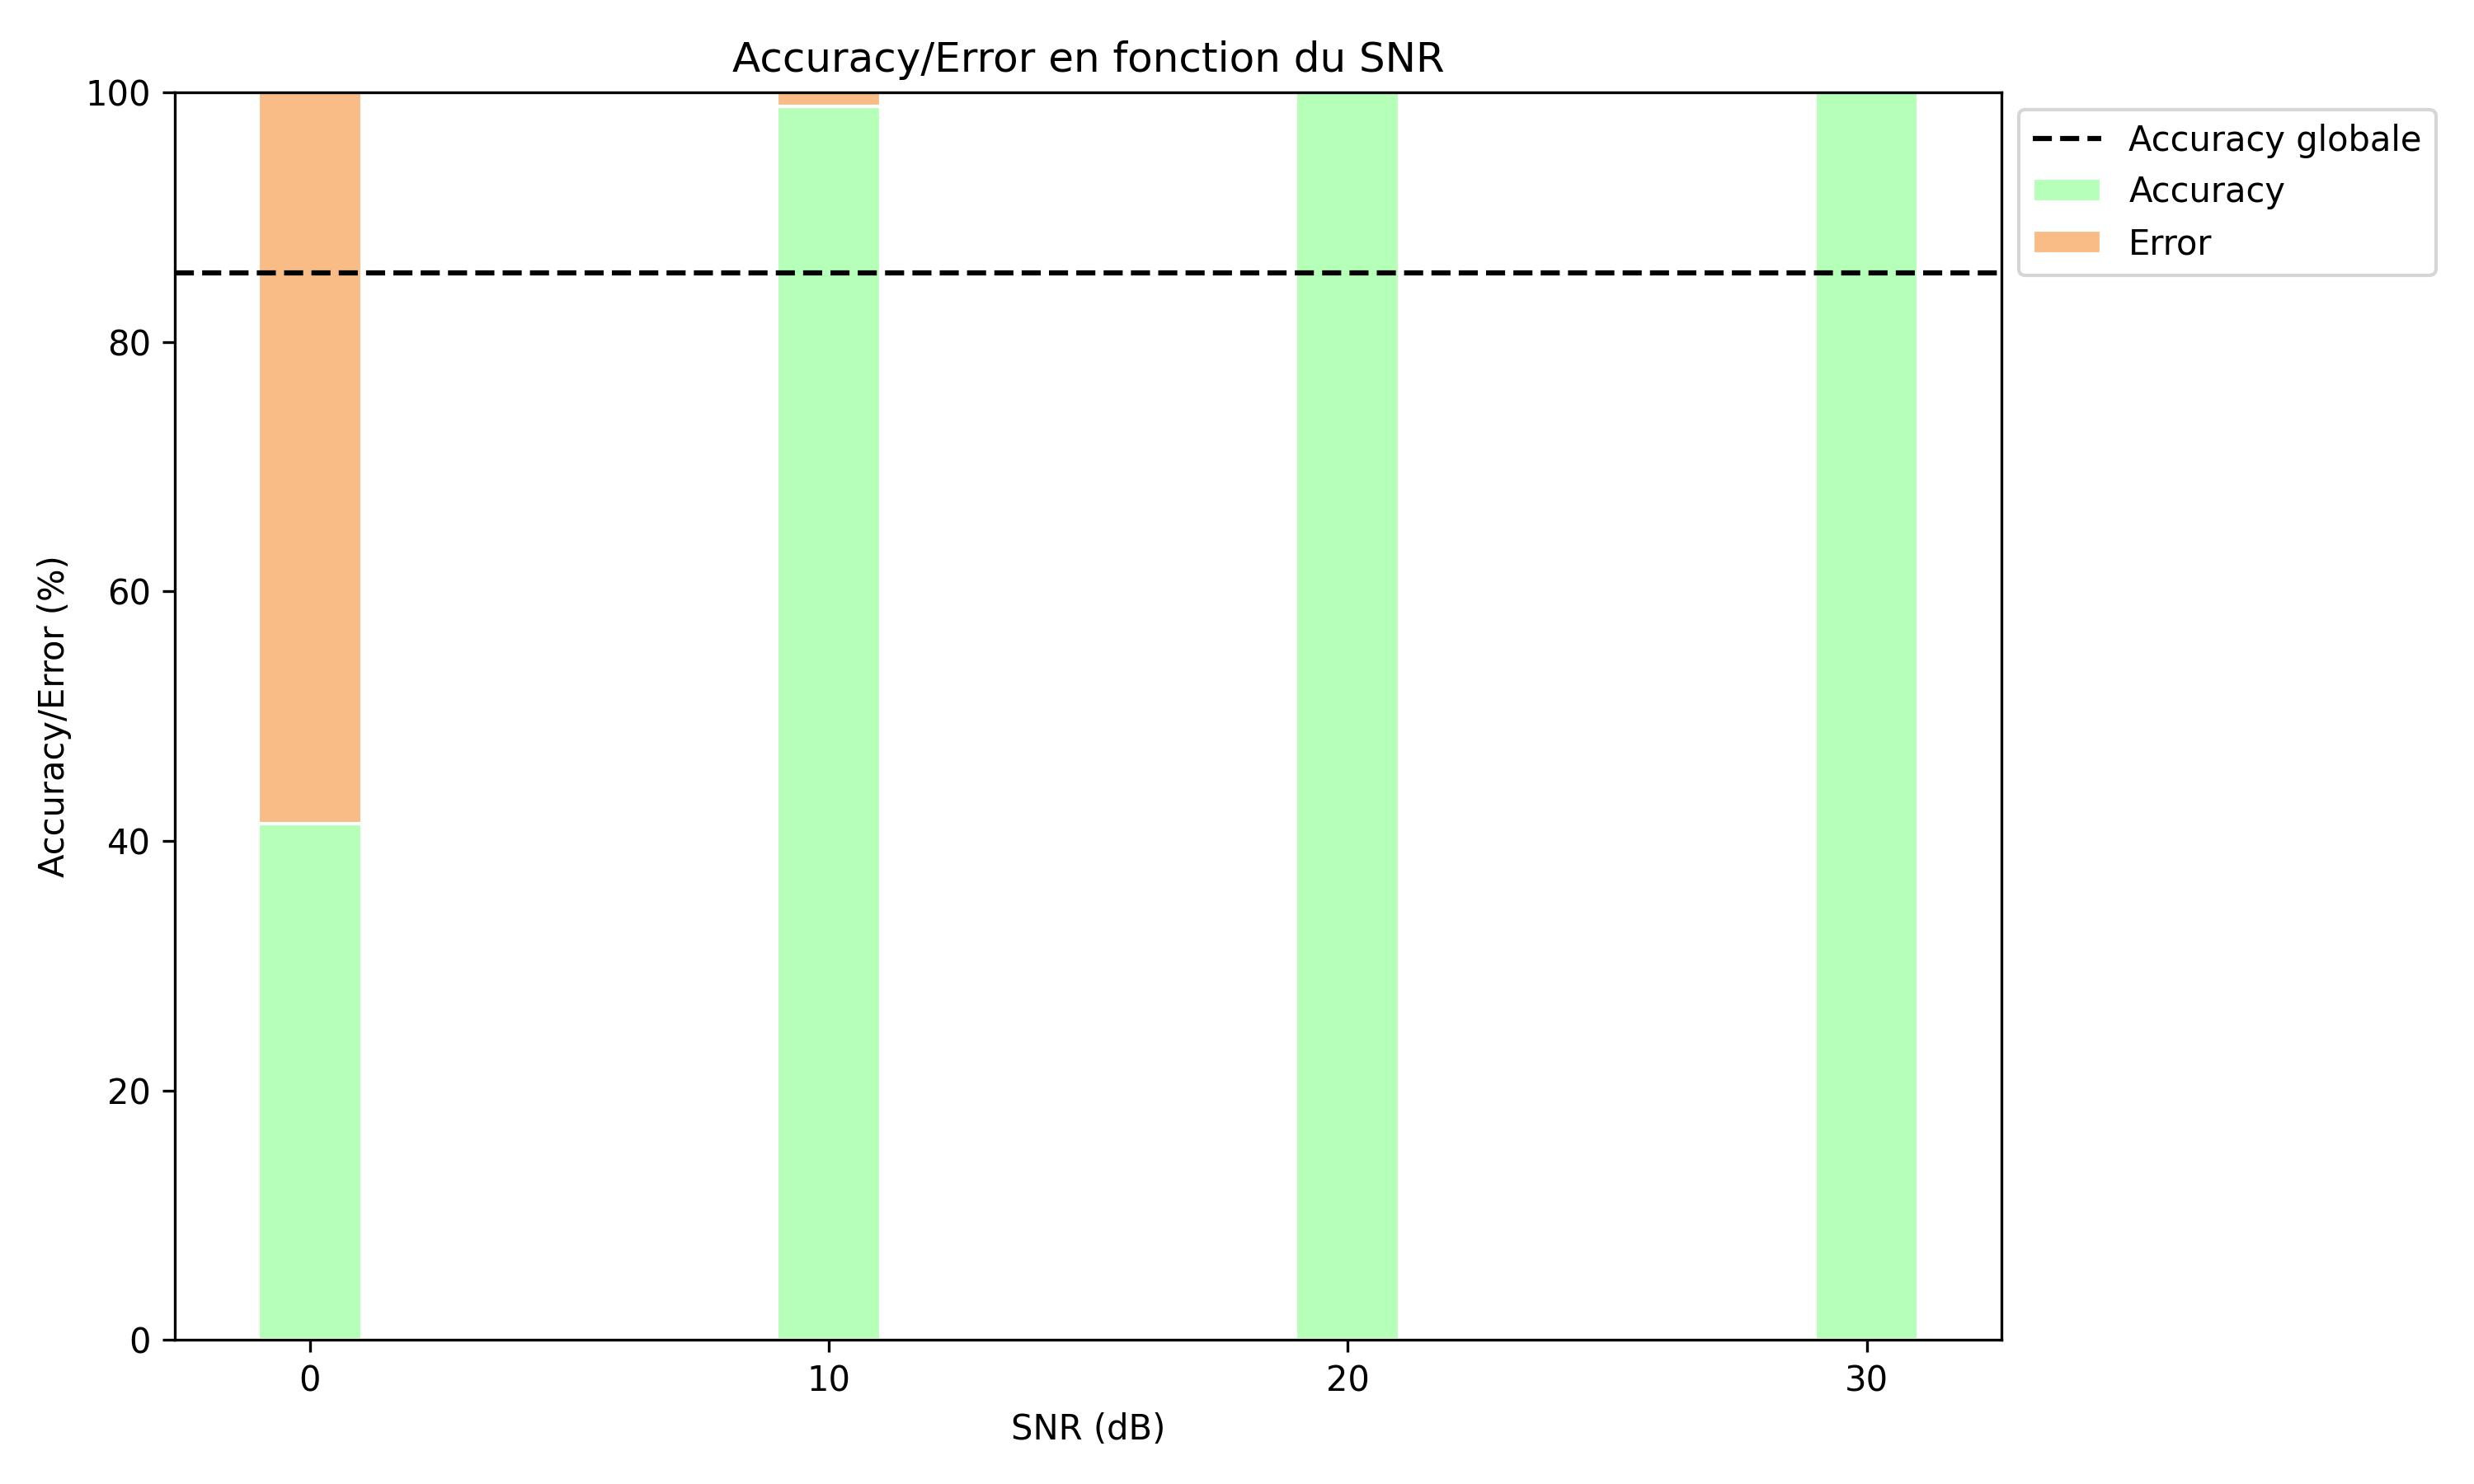

In [181]:
from IPython.display import Image, display

# Afficher l'image
display(Image(filename='./modele3plot.jpg'))


### Observations

Le modèle présente une **accuracy globale de 85%**, ce qui est satisfaisant dans l'ensemble.

- **Pour les SNR de 10, 20, 30 et 40**, l'accuracy est excellente, dépassant **98%** dans chaque cas. Cela montre que le modèle est particulièrement performant lorsque le signal est de bonne qualité.
- **Pour le SNR = 0**, le modèle rencontre des difficultés importantes. Cela indique qu'il a du mal à détecter la classe du signal lorsque le rapport signal/bruit est inexistant, ce qui est un cas extrême.

---

### Conclusion

Ce projet a permis de se familiariser avec **PyTorch** et l'implémentation de réseaux de neurones convolutifs (**CNN**) pour la classification de signaux. Nous avons également exploré les étapes essentielles de conception d'un modèle, de son entraînement, et de l'évaluation de ses performances.

Pour obtenir de bons résultats, il est crucial de concevoir une architecture capable de produire un **embedding représentatif**, permettant une classification précise dans les couches finales. Par ailleurs, le choix des hyperparamètres, notamment le **learning rate** et l'**optimizer**, joue un rôle déterminant dans les performances du modèle.

---

### Perspectives d'amélioration

Pour améliorer les performances du modèle, notamment pour le cas du SNR = 0, plusieurs pistes peuvent être envisagées :

1. **Utilisation d'autres architectures** :
   - Essayer des modèles plus avancés ou spécialisés pour la classification de signaux, comme des réseaux basés sur des **transformers** ou des architectures hybrides combinant CNN et RNN.
   
2. **Augmentation des données** :
   - Appliquer des techniques d'augmentation de données ou de **feature engineering**, comme l'ajout de bruit simulé ou la transformation des caractéristiques du signal, afin d'améliorer la robustesse du modèle.

3. **Entraînement ciblé pour SNR = 0** :
   - Développer un modèle dédié à la classification des signaux avec un SNR faible ou nul. Par exemple :
     - Construire un modèle préliminaire pour estimer le SNR du signal (0 vs. 10–40).
     - Réentraîner un second modèle spécifiquement sur les signaux avec un SNR = 0, afin d'améliorer leur classification.

En suivant ces approches, le modèle pourrait devenir plus robuste et performant, même dans des conditions de bruit élevé.


FIN du notebook

Merci pour votre lecture !

**Blandine Gorce** et **Thomas Gravier**